```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [25]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc


#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [26]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation, ParticleInfo
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting


In [27]:
%cuda_context_handler gpu_ctx

# Read observation file and plot some results

In [28]:
from SWESimulators import SimReader
#observation_file = "2019-12-02/lovese/observation_10_05_44.pickle"
#truth_reader = SimReader.SimNetCDFReader("2019-12-02/lovese/lovese_original.nc")

#observation_file = "2019-12-03/lovese/opendrift_observations_18_08_56.pickle"
#truth_reader = SimReader.SimNetCDFReader("2019-11-28/lovese/lovese_original.nc")

observation_file = "2019-12-03/lovese/opendrift_observations_15_06_29.pickle"



### Using interpolation factor 7
#result_folder = 'EPS_2019_11_30-19_35_00/' # Example using    default q0: 8e-3
#result_folder = 'EPS_2019_11_30-19_09_17/' # Example using very small q0: 1e-5
#result_folder = 'EPS_2019_11_30-19_38_52/' # Example using      small q0: 1e-4
#result_folder = 'EPS_2019_11_30-19_50_45/' # Example using      large q0: 1e-3
#result_folder = 'EPS_2019_11_30-19_58_41/' # Example using     medium q0: 5e-4
#result_folder = 'EPS_2019_11_30-20_15_17/' # Example using      small q0: 0.7e-4
#result_folder = 'EPS_2019_11_30-20_18_59/' # Example usingquite small q0: 0.5e-4


### Using interpolation factor 9
#result_folder = 'EPS_2019_11_30-20_02_26/' # Example using     medium q0: 5e-4
#result_folder = 'EPS_2019_11_30-20_06_38/' # Example using      small q0: 1e-4

### Using interpolation factor 5
#result_folder = 'EPS_2019_11_30-20_09_39/' # Example using      small q0: 1e-4
#result_folder = 'EPS_2019_11_30-20_12_57/' # Example using      small q0: 0.7e-4

# With random q0 and random cov-radius
#result_folder = 'EPS_2019_11_30-20_22_57/' # Example q0 [0.5e-4 - 7.5e-4]
#result_folder = 'EPS_2019_11_30-20_29_16/' # Example q0 [0.5e-4 - 5e-4]
#result_folder = 'EPS_2019_11_30-20_40_59/' # Example q0 [0.3e-4 - 3e-4]


### With DA
#result_folder = 'EPS_2019_11_30-20_46_41/' # Example q0 [0.5e-4 - 5e-4]
#result_folder = 'EPS_2019_11_30-20_57_37/' # Example q0 [0.5e-4 - 5e-4]

### DGX-2 results
#result_folder = 'EPS_2019_12_03-14_25_42/'
#result_folder = 'EPS_2019_12_03-19_36_33/'

# mpirun -n 16 python3 sequential_importance_resampling.py --per_node_ensemble_size 63 --observation_file 2019-12-03/lovese/opendrift_observations_15_06_29.pickle --observation_variance 10 --resampling_frequency_minutes 30 --data_assimilation_end_hours 48 --forecast_duration_hours 47
result_folder = 'EPS_2019_12_04-16_44_55/'


eta = truth_reader.getLastTimeStep()[0]

obs = Observation.Observation(observation_type=dautils.ObservationType.UnderlyingFlow,
                              domain_size_x=truth_reader.get("nx")*truth_reader.get("dx"), domain_size_y=truth_reader.get("ny")*truth_reader.get("dy"),
                              nx=truth_reader.get("nx"), ny=truth_reader.get("ny"),
                              land_mask=eta.mask)
obs.read_pickle(observation_file)

In [29]:
particle_info_dir = os.path.join(result_folder, "particle_info")
filenames = os.listdir(particle_info_dir)

particle_infos = [None] * len(filenames)
for i in range(len(particle_infos)):
    particle_infos[i] = ParticleInfo.ParticleInfo()
    particle_infos[i].read_pickle(os.path.join(particle_info_dir, filenames[i]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(5700,)
<class 'numpy.ndarray'> (5700,)


/modules/centos7/python/3.7.2/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/modules/centos7/python/3.7.2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


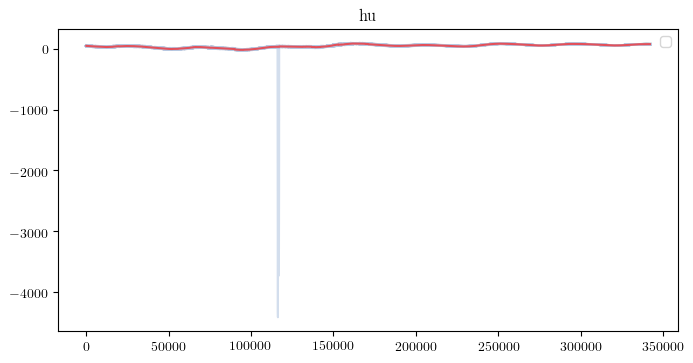

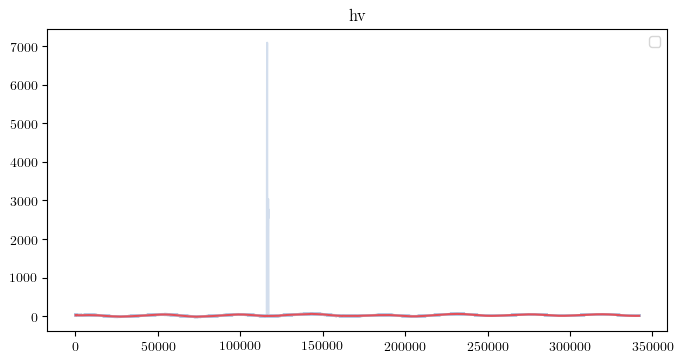

In [30]:
extra_cell_id = 19


def state_at_recorded_cell(extra_cell_id):

    def get_time_series_for_particle(particle_info, extra_cell_id):

        time  = particle_info.get_sample_times()
        hu = np.empty_like(time)
        hv = np.empty_like(time)

        all_buoy_obs = particle_info.state_df["extra_states"]
        for t in range(len(time)):
            hu[t] = all_buoy_obs[t][extra_cell_id,1]
            hv[t] = all_buoy_obs[t][extra_cell_id,2]

        return time, hu, hv

    #obs_t, obs_hu, obs_hv = get_time_series_for_buoy(obs, buoy_id)

    fig = plt.figure(figsize=(8,4))
    plt.legend()
    plt.title('')

    t, _, _ = get_time_series_for_particle(particle_infos[0], extra_cell_id)
    hu_mean = np.zeros_like(t)
    for particle_info in particle_infos:
        t, hu, _ = get_time_series_for_particle(particle_info, extra_cell_id)
        hu_mean += hu
        plt.plot(t, hu, color='xkcd:light blue grey', alpha=0.6)

    hu_mean = hu_mean/len(particle_infos)
    plt.plot(t, hu_mean, color="red", alpha=0.6)
    #plt.plot(obs_t[:25], obs_hu[:25])
    plt.title("hu")

    fig = plt.figure(figsize=(8,4))
    plt.legend()
    plt.title('')

    hv_mean = np.zeros_like(t)
    for particle_info in particle_infos:
        t, _, hv = get_time_series_for_particle(particle_info, extra_cell_id)
        hv_mean += hv
        plt.plot(t, hv, color='xkcd:light blue grey', alpha=0.6)


    hv_mean = hv_mean/len(particle_infos)
    plt.plot(t, hv_mean, color="red", alpha=0.6)
    #plt.plot(obs_t[:25], obs_hv[:25])
    plt.title("hv")

    #plt.xlim([800, 1000])

    print(t.shape)
    print(type(hu), hu.shape)

state_at_recorded_cell(extra_cell_id)

# Plot drifter trajectory forecast

In [31]:
drifter_forecast_dir = os.path.join(result_folder, "forecast_observation_files")
filenames = os.listdir(drifter_forecast_dir)

drifter_forecast = [None] * len(filenames)
for i in range(len(drifter_forecast)):
    drifter_forecast[i] = Observation.Observation(domain_size_x=truth_reader.get("nx")*truth_reader.get("dx"), domain_size_y=truth_reader.get("ny")*truth_reader.get("dy"),
                              nx=truth_reader.get("nx"), ny=truth_reader.get("ny"),
                              land_mask=eta.mask)
    drifter_forecast[i].read_pickle(os.path.join(drifter_forecast_dir,filenames[i]))

In [46]:
#drifter_id = 41
#drifter_id = 84
drifter_id = 85
#drifter_id = 103


#start_time_forecast = 60*60
#end_time_forecast = 2*60*60

start_time_forecast = 48*60*60
end_time_forecast = 95*60*60




drifter_paths = [None]*len(drifter_forecast)
for i in range(len(drifter_paths)):
    drifter_paths[i] = drifter_forecast[i].get_drifter_path(drifter_id, start_time_forecast, end_time_forecast)
    
truth_paths = obs.get_drifter_path(drifter_id, start_time_forecast, end_time_forecast)

mean_path = drifter_forecast[0].get_drifter_path(drifter_id,  
                                                 start_time_forecast,
                                                 end_time_forecast,
                                                 keepDomainSize=False)[0]
num_paths_in_mean = 1
            
for i in range(1, len(drifter_forecast)):
    tmp_mean_path = drifter_forecast[i].get_drifter_path(drifter_id,  
                                                         start_time_forecast,
                                                         end_time_forecast,
                                                         keepDomainSize=False)[0]
    if not np.isnan(tmp_mean_path).any():
        mean_path += tmp_mean_path
        num_paths_in_mean += 1
                    
mean_path /= num_paths_in_mean

1
(2820, 2)


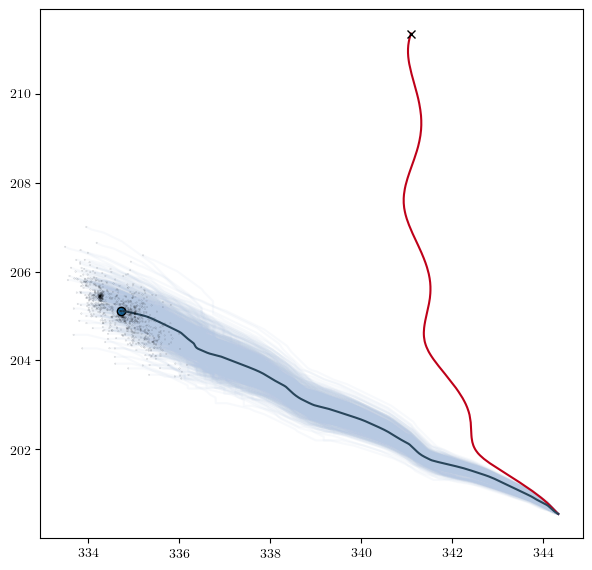

In [51]:
def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None]):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.1)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                      forecast_point_size, 
                                                      fill=False, zorder=10,
                                                      alpha=0.7)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    if mean_paths[0] is not None:
        #xend = matplotlib.patches.Circle((mean_paths[-1][-1,0], mean_paths[-1][-1,1]),
        #                                 truth_point_size,
        #                                 fill=False, zorder=10)
        #ax.add_patch(xend)
        ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
                   marker='o', markeredgecolor='k', markerfacecolor=None)
        
def createForecastCanvas(observation):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = observation.nx
    ny = observation.ny
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    
    extent=np.array([0, observation.domain_size_x, 0, observation.domain_size_y])/1000
    ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    return ax



#ax = createForecastCanvas(obs)
fig, axs = plt.subplots(1, 1, figsize=(7,7))

print(len(drifter_paths[0]))
print(drifter_paths[0][0].shape)
forecastPlot(axs, truth_paths, drifter_paths, forecast_point_size=0.001, truth_point_size=0.001, mean_paths=[mean_path])


In [18]:
for i in range(10):
    print(np.random.rand()*10)

1.543148099901912
7.892348888878077
7.50262543634856
1.4921965253444303
2.118980127200923
6.074073595836715
5.1521365543958995
6.56342606020174
7.638772464453228
9.241854479593862
